In [1]:
!pip install sklearn

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10
from sklearn.preprocessing import LabelBinarizer

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [6]:
X_train = X_train / 255.0
X_test = X_test / 255.0

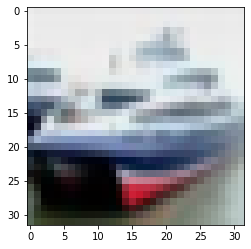

In [7]:
plt.imshow(X_test[1])

In [8]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

In [9]:
lr = 0.01 
comms_round = 100
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer = tf.keras.optimizers.SGD(lr=lr, decay= lr/comms_round, momentum=0.9)    

In [10]:
n_clients = 5

In [11]:
def generate_indexes(X, n_clients):
    indexes = np.arange(np.random.randint(int(X.shape[0] * 0.8), X.shape[0]))
    
    np.random.shuffle(indexes)
    indexes = np.array_split(indexes, n_clients)
    
    clients_index = np.arange(n_clients)
    np.random.shuffle(clients_index)
    
    half_clients = int(n_clients / 2)
    samples = np.random.random_sample((half_clients,))
    for i in range(half_clients):
        client_A = indexes[clients_index[i]]
        client_B = indexes[clients_index[i + half_clients]]
        
        client_A = np.concatenate((client_A, client_B[:int(client_B.shape[0] * samples[i])]))
        client_B = client_B[int(client_B.shape[0] * samples[i]):]
        
        indexes[clients_index[i]] = client_A
        indexes[clients_index[i + half_clients]] = client_B
    
    return indexes

In [12]:
def create_clients(X, y, n_clients):

    indexes = generate_indexes(X, n_clients)
    
    X_slices = np.array([X[indexes[i]] for i in range(n_clients)], dtype='object')
    y_slices = np.array([y[indexes[i]] for i in range(n_clients)], dtype='object')
    return X_slices, y_slices

In [13]:
class CNN:
    def build(self):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=[32,32,3]))
        model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
        model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
        model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
        model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
        model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(units=128, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.Dense(units=64, activation='tanh'))
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.Dense(units=64, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.Dense(units=32, activation='tanh'))
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.Dense(units=10, activation='softmax'))
        return model

In [14]:
def NN_update(local_data, global_data, model):    
    weights = (local_data / global_data) * np.array(client_model.get_weights(), dtype='object')
    
    return weights

In [15]:
mlp = CNN()

global_model = mlp.build()
global_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

for j in range(comms_round):

    global_weights = global_model.get_weights()
    new_global_weights = [np.zeros(weight.shape) for weight in global_weights]
    
    X_slices, y_slices = create_clients(X_train, y_train, n_clients)
    global_data = sum([size.shape[0] for size in X_slices])
    
    for i in range(n_clients):
        client_model = mlp.build()
        client_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        client_model.set_weights(global_weights)
        client_model.fit(X_slices[i], y_slices[i], epochs=2, verbose=0)
        
        weights = NN_update(X_slices[i].shape[0], global_data, client_model)
        
        new_global_weights += np.array(weights, dtype='object')
    
    global_model.set_weights(new_global_weights)
    
    test_loss, test_accuracy = global_model.evaluate(X_test, y_test)
    print("Round {}, Loss: {:.3f}, Accuracy: {:.3f}".format(j, test_loss, test_accuracy))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


313/313 [==============================] - 1s 2ms/step - loss: 2.0853 - accuracy: 0.2452
Round 0, Loss: 2.084, Accuracy: 0.240
313/313 [==============================] - 1s 2ms/step - loss: 1.4875 - accuracy: 0.4565
Round 1, Loss: 1.488, Accuracy: 0.456
313/313 [==============================] - 1s 2ms/step - loss: 1.3264 - accuracy: 0.5172
Round 2, Loss: 1.326, Accuracy: 0.517
313/313 [==============================] - 1s 2ms/step - loss: 1.2128 - accuracy: 0.5609
Round 3, Loss: 1.213, Accuracy: 0.561
313/313 [==============================] - 1s 2ms/step - loss: 1.1040 - accuracy: 0.6097
Round 4, Loss: 1.104, Accuracy: 0.610
313/313 [==============================] - 1s 2ms/step - loss: 1.0396 - accuracy: 0.6357
Round 5, Loss: 1.040, Accuracy: 0.636
313/313 [==============================] - 1s 2ms/step - loss: 0.9795 - accuracy: 0.6635
Round 6, Loss: 0.979, Accuracy: 0.664
313/313 [==============================] - 1s 2ms/step - loss: 0.9405 - accuracy: 0.6791
Round 7, Loss: 0.941, 